# Part IV -  ML For Interpersonal Physical Alignment
#####  @ Haim Goldfisher

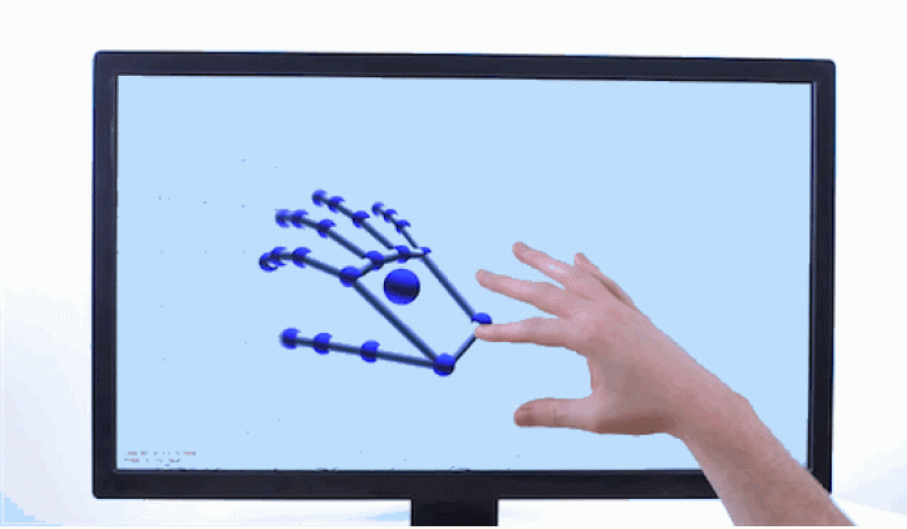

# Libraries Importation:

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#import warnings & offline
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as pyo

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Data Preprocessing:

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, roc_auc_score, accuracy_score, make_scorer

# Models:

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# A model that I learned by myself: CatBoost + Plotly

from catboost import CatBoostClassifier
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

# Clustering:

from sklearn.cluster import KMeans

# PCA:

from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

# Scaling:

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross Validation:

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Brief Summary:

The purpose of the work is to classify between three different situations in the way people communicate with each other:
- The first is Spontaneous (autonomous) situation in which two people move their hands freely in front of each other.
- The second is a synchronous movement in which the two people move their hands together. 
- The third is a movement in position own (alone). Where only one side moves the hands.

The idea is to look at the patterns of the hands and try to deduce from them whether it is a situation alone, spontaneous or synchronous.

The experiment is based on synchronization between two people. That is, they both "transmit on the same wave" so that no one is leading this synchronization. In this case the argument is that there is not one "brain" of the two that leads but two brains of two people uniting into a spring of cooperation that is supposedly above both of them, which controls their movements in the synchronization process.

The experiment uses a system that captures the position of a person's hands. The system knows where the hand is. The experiment places two people facing each other. The experiment operation tells them to move their hands in front of each other spontaneously. He then asks them to be in sync (the process causes both parties to try to be in sync). People begin to perceive each other in order to understand the other side (there must be no imitation of one side, otherwise it does not work). We have three situations: alone, spontaneous in front of another person and in sync with another person.

Assumption of the experiment: The felt state will necessarily be different from the spontaneous state. That is, an experience of looking at another person, the connection between them automatically changes the movement of the two people (as long as they do not have autism). Also, the distance between the two people should be taken into account, because a person alone will move freely when there is no person next to him that he can hurt. In contrast, people who stand relatively close will inevitably move in more measured movements so as not to accidentally hurt each other.

Note, the literature defines synchronization as a product of a velocity vector. When people are in sync, they have the same velocity vector. The above experiment examines the definition of synchronization as the location of the two entities to each other at a given time.

# A Little Bit About The Data:

##### Documentation: https://developer-archive.leapmotion.com/documentation/python/api/Leap.Hand.html

# Strategy:

We would like to work with TimeSeries to classify the variance during the time. Moreover, we know that 

Work only with training data. Do not touch on validation during model preparation but only at the prediction stage.
We have in the experiment 9 people who each have data depending on the people they were in front of (maybe there is a difference between the people who were in front of them or their order).
If both hands do not appear at the same time - not correct. (Should be both right and left for all time \ ID ie time \ ID must appear twice, otherwise it must be removed).
Usually a second recording is better because the person has already gotten used to the state of the experiment.
Please note, TRAINING is the first 40 seconds, TESTING is the last 20 seconds. This is obligatory from reality because there is a clear correlation between what happened before the moment and what will happen or happened a moment before or after. That is, the position of the hand in one frame and in the frame after it will always be very close.
It is recommended to take a maximum of 4 frames per second (if you want to get rid of a certain part of the data, you can for example take two samples from the data every second, assuming it does not go so far during the second - if the download does not hurt the model, but no more than 4 frames per second).
Recommended way of working - build a model for one person. Then try it on another person and then fix so that the model "catches" the two people and so on.
The conclusion of the experiment: The position vector exceeds the velocity vector. Synchronization is expressed in the need of the two people to find synchronization at the level of their location opposite each other, and not the same speed of movement.

# Datasets & Data Preprocessing:

Following the instructions, I filtered the CSV files before loading them. That is, I removed the unnecessary files so that in each folder only the three relevant files (the last three) would appear. Also, depending on what was required, the first 7 seconds were removed from each CSV file (using pandas method).

In [2]:
# inner fuction to add HandRight to 'Alone's files, and fit their 'Time' & 'Frame ID' values into left's values

def alone_handright(dataframe):
    
    df = dataframe.copy()
    df = df[df[' Hand Type']=='left'] # drop right from alone
    df.reset_index(drop=True, inplace=True) # reset to index after dropping some of the rows
    right = pd.read_csv(r'C:\Haim\Anaconda\Experiment\HandRight.csv') # upload HandRight CSV
    right = (right[right["Time"] > (right["Time"][0]+7)]) # the 7 first second are being removed (just like left)
    right.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True) # drop rows with null values
    min_len = min(len(right), len(df)) # we want to merge each left with right, their amount must be the same
    df, right = df[:min_len], right[:min_len] # resize each df into the min amount of rows
    right.drop(['Time', ' Frame ID'], axis=1, inplace=True) # we will add left
    right['Time'] = list(df['Time']) # right's time becomes left's time
    right[' Frame ID'] = list(df[' Frame ID']) # right's frame id becomes left's frame id
    df = pd.concat([right, df], axis=0).sort_index() # concat left & right into one df
    
    return df

In [3]:
# inner function to perform the required changes on the data

def pandas_preprocessing(dataframe):
    df = dataframe.copy()
    left = df.loc[df[' Hand Type']=='left'] # create df of only left
    right = df.loc[df[' Hand Type']=='right'] # create df of only right
    df = pd.merge(left, right, how='outer', on=['Time', ' Frame ID', ' # hands']) # merge them on equal features
    # this merge fuction created new feqtures for right hand so both hands are in the same row
    df.drop([' Hand Type_x', ' Hand Type_y', ' # hands'], axis=1, inplace=True) # drop useless columns
    df.dropna(axis = 0, inplace=True, how="any") # for left which has no right or the opposite case
    df = df[df.index % 12 == 0] # every second has 60 timestamps in the csv, we will take 5 timestamps from each second
    
    return df
    

In [4]:
# this main function gets a folder name (Train or Validation) and create a df from all csv file the folder has

def upload(path):
    folders = glob.glob(path + "/*") # the folder of all folders
    data = [] # output list
    labels = ["Alone", "Spontan", "Sync"] # all options
    for folder_name in folders: # run over the folders
        files = glob.glob(folder_name + "/*.csv") # the csv files
        for filename in files: # run over each csv in the folder
            df = pd.read_csv(filename, index_col=None, header=0) # read the currect csv file
            df = (df[df["Time"] > (df["Time"][0]+7)]) # the 7 first second are being removed
            for label in labels: # it checks which one of the 3 labels this csv is
                if label in filename: # for adding the correct label to the correct df
                    if label == 'Alone': # unique function for alone???
                        df = alone_handright(df) # add hand right to the csv
                    if "Train"  in folder_name: # for Train upload:
                        experimenter = folder_name.split('g')[1][1:] # for train df
                    else: # for Test upload:
                        experimenter = folder_name.split('n')[4][1:] # for validation df
                    df = pandas_preprocessing(df) # do the required changes on the df
                    df["Label"] = label # new feature with the label name
                    df["Name"] = experimenter # new feature with the experimenter name                     
            data.append(df) # add the new df to the list
    result = pd.concat(data, axis=0, ignore_index=True) # concat all data frames into one 
    return result

In [5]:
path = "C:\Haim\Anaconda\Experiment\Training"
df_train = upload(path)

In [6]:
df_train.head(3)

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label,Name
0,71.41422,98073,-109.8061,228.3820,87.32578,-41.53802,116.70710,-60.09788,2.147859,0.867143,...,166.6150,15.43945,313.4828,3.741617,144.8563,0.0,0.229723,0.0,Spontan,Evyatar Cohen
1,71.61286,98095,-116.0819,262.2935,69.38125,-41.95232,67.29385,-164.57100,1.846896,0.988885,...,191.1658,46.16781,342.6233,6.987622,110.2244,0.0,0.222867,0.0,Spontan,Evyatar Cohen
2,71.81174,98118,-124.0690,272.8058,84.45541,-30.37846,-82.30848,294.65090,1.887822,1.037487,...,196.6065,77.48891,334.9969,-1.636652,113.0903,0.0,0.377240,0.0,Spontan,Evyatar Cohen


In [7]:
df_train.shape

(14444, 40)

In [8]:
df_train.groupby('Label').count()

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Name
Label,,,,,,,,,,,,,,,,,,,,,
Alone,4426,4426,4426,4426,4426,4426,4426,4426,4426,4426,...,4426,4426,4426,4426,4426,4426,4426,4426,4426,4426
Spontan,5041,5041,5041,5041,5041,5041,5041,5041,5041,5041,...,5041,5041,5041,5041,5041,5041,5041,5041,5041,5041
Sync,4977,4977,4977,4977,4977,4977,4977,4977,4977,4977,...,4977,4977,4977,4977,4977,4977,4977,4977,4977,4977


In [9]:
df_train.groupby('Name').count()

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label
Name,,,,,,,,,,,,,,,,,,,,,
Evyatar Cohen,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015,...,2015,2015,2015,2015,2015,2015,2015,2015,2015,2015
Nofar Social_Nuero,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
Oriya Social_Nuero,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,...,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306
Orya Kalmanovitz,1645,1645,1645,1645,1645,1645,1645,1645,1645,1645,...,1645,1645,1645,1645,1645,1645,1645,1645,1645,1645
Revital Marbel,1588,1588,1588,1588,1588,1588,1588,1588,1588,1588,...,1588,1588,1588,1588,1588,1588,1588,1588,1588,1588
Shahar Terner,1007,1007,1007,1007,1007,1007,1007,1007,1007,1007,...,1007,1007,1007,1007,1007,1007,1007,1007,1007,1007
Shelly Social_Nuero,1945,1945,1945,1945,1945,1945,1945,1945,1945,1945,...,1945,1945,1945,1945,1945,1945,1945,1945,1945,1945
Yael Ha,963,963,963,963,963,963,963,963,963,963,...,963,963,963,963,963,963,963,963,963,963
Yoel Raz,975,975,975,975,975,975,975,975,975,975,...,975,975,975,975,975,975,975,975,975,975


In [10]:
path = "C:\Haim\Anaconda\Experiment\Validation"
df_test = upload(path)

In [11]:
df_test.shape

(3970, 40)

In [12]:
# we will map our labels & Names into numbers:

mapping = {'Alone':0, 'Spontan':1, 'Sync':2}
df_train.Label = df_train.Label.map(mapping)
df_test.Label = df_test.Label.map(mapping)

encoder = LabelEncoder()
df_train['Name'] = encoder.fit_transform(df_train['Name'])

df_train.head(3)

,Time,Frame ID,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,Pitch_x,Roll_x,...,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y,Label,Name
0,71.41422,98073,-109.8061,228.3820,87.32578,-41.53802,116.70710,-60.09788,2.147859,0.867143,...,166.6150,15.43945,313.4828,3.741617,144.8563,0.0,0.229723,0.0,1,0
1,71.61286,98095,-116.0819,262.2935,69.38125,-41.95232,67.29385,-164.57100,1.846896,0.988885,...,191.1658,46.16781,342.6233,6.987622,110.2244,0.0,0.222867,0.0,1,0
2,71.81174,98118,-124.0690,272.8058,84.45541,-30.37846,-82.30848,294.65090,1.887822,1.037487,...,196.6065,77.48891,334.9969,-1.636652,113.0903,0.0,0.377240,0.0,1,0


In [13]:
# A function to show the labels
def num_to_name(label):
    labeled = label.copy()
    mapping = {0 :'Alone',
    1 :'Spontan',
    2 :'Sync'}
    labeled = label.map(mapping)
    return labeled

In [14]:
target = df_train['Label'] # the feature we would like to predict, the label of picture
data = df_train.drop(['Name','Label',' Frame ID','Time'], axis = 1) # we will drop y from x, because we want to predict it

# Explore The Data:

In [18]:
df_train.isna().sum().sum(), df_test.isna().sum().sum() # no NaN values in df_train & df_test

(0, 0)

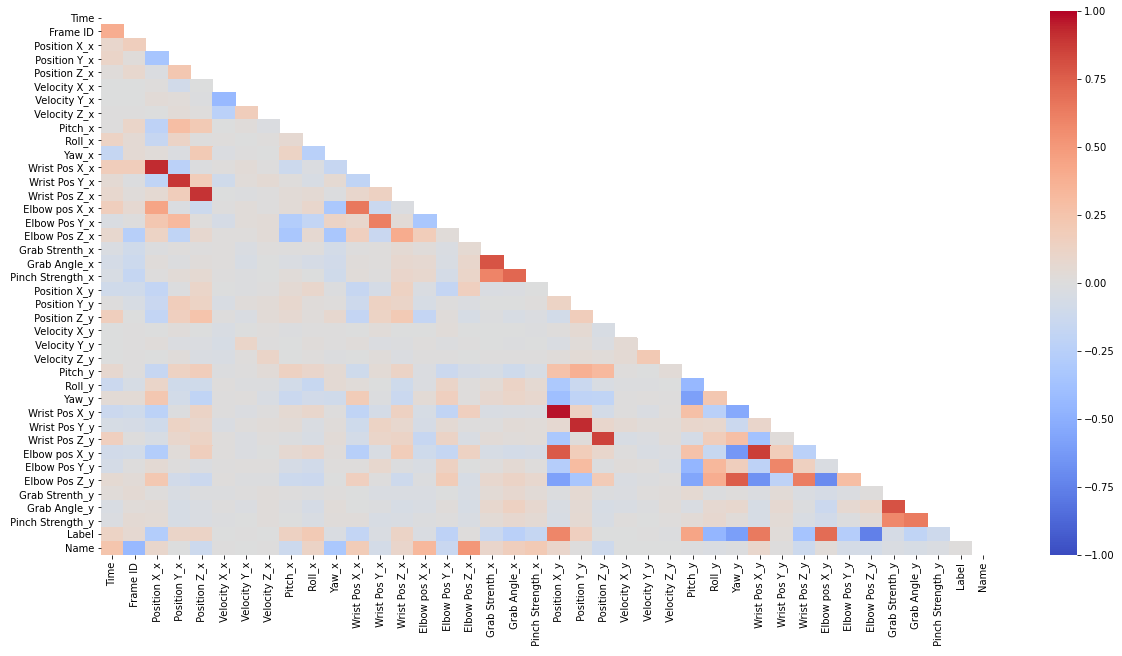

In [33]:
# correalation between each feature by heatmap

plt.figure(figsize=(20, 10))
matrix = np.triu(df_train.corr())
sns.heatmap(df_train.corr(min_periods=0.5), square=False, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix);

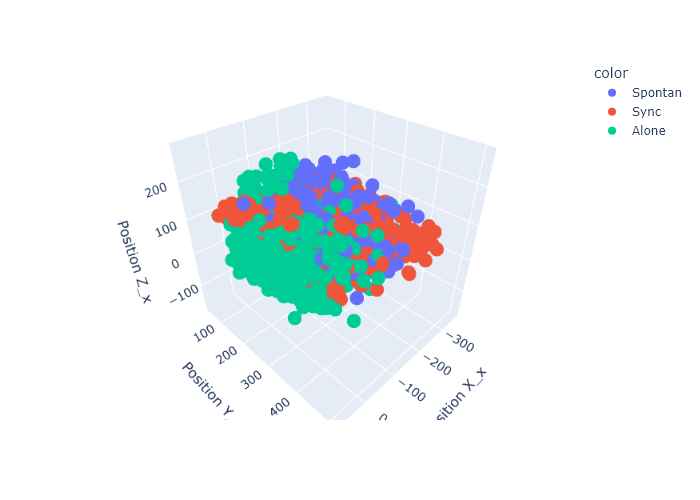

In [74]:
fig = px.scatter_3d(data, x=' Position X_x', y=' Position Y_x', z=' Position Z_x',
              color=num_to_name(target))
fig.show("png")

In [56]:
# lets take a look at every label from Evyatar folder

spontan = pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Evyatar Cohen\Evyatar636771052727603804Spontan.csv')
sync = pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Evyatar Cohen\Evyatar636771053639929594Sync.csv')
alone = alone_handright(pd.read_csv(r'C:\Haim\Anaconda\Experiment\Training\Evyatar Cohen\Evyatar636771054555711409Alone.csv'))

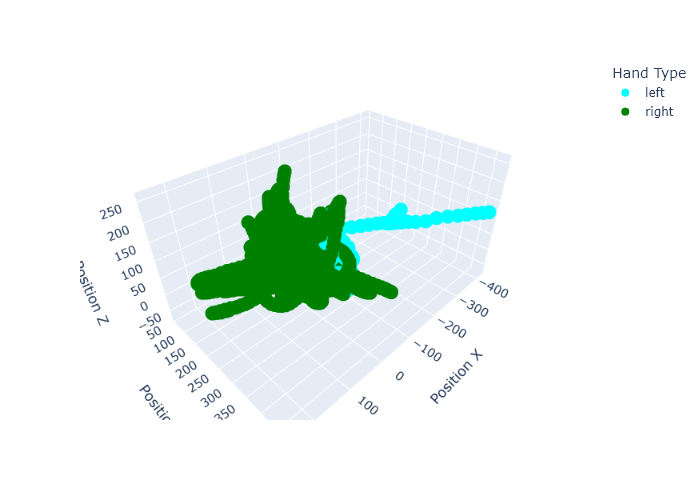

In [67]:
# an example of 'Alone'

fig = px.scatter_3d(alone, x =' Position X', y =' Position Y', z =' Position Z' ,
                    color=' Hand Type', color_discrete_sequence=["cyan", "green"])
fig.show("png")

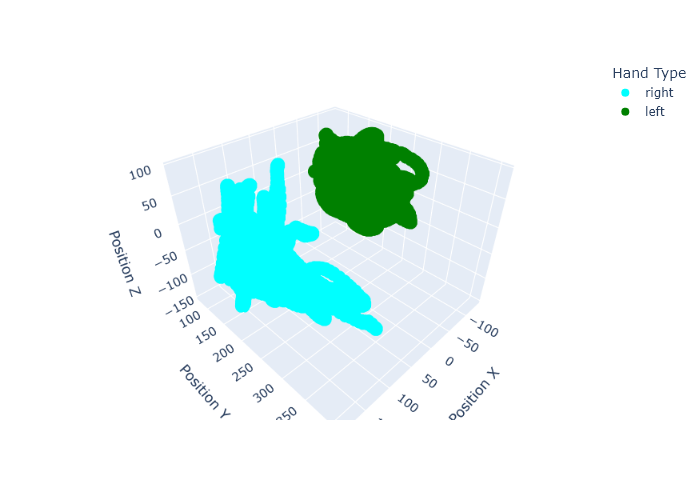

In [64]:
# an example of 'Spontan'

fig = px.scatter_3d(spontan, x =' Position X', y =' Position Y', z =' Position Z' ,
                    color=' Hand Type', color_discrete_sequence=["cyan", "green"])
fig.show("png")

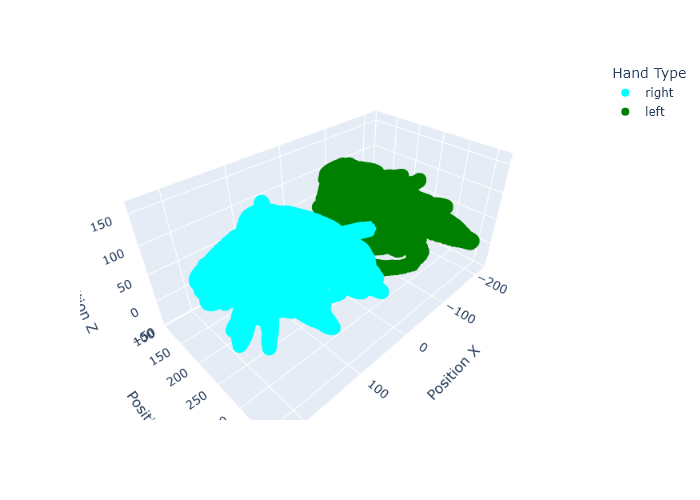

In [65]:
# an example of 'Sync'

fig = px.scatter_3d(sync, x =' Position X', y =' Position Y', z =' Position Z' ,
                    color=' Hand Type', color_discrete_sequence=["cyan", "green"])
fig.show("png")

##### One of the easiest things to notice is that in 'Alone' situation, the two hands intersect because the two people were alone in the room and could move freely. Another thing that is unusually interpreted from the graph is that there is a significant difference between a 'Spontan' situation and a 'Sync' situation. It is clear that classification process should not be too difficult.

# Train / Test Split:

In [93]:
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, random_state=18)

# Scaling:

In [114]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Dimensionality Reduction:

In [115]:
pca = PCA()
pca.fit(X_train)

PCA()

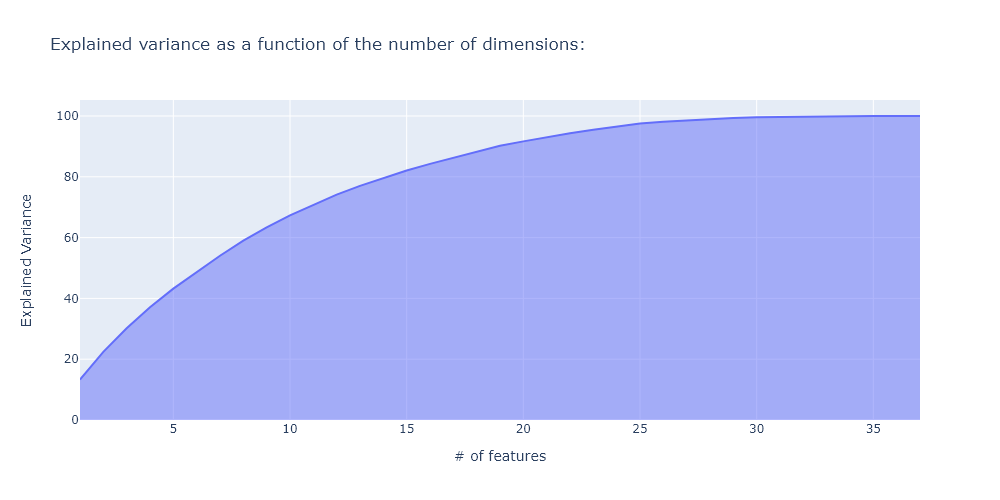

In [116]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    title = "Explained variance as a function of the number of dimensions:",
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul * 100,
    labels={"x": "# of features", "y": "Explained Variance"},
    width = 1000 ,
    height = 500
)
fig.show("png")

In [117]:
pca = PCA(n_components=0.95) # we can try using svd_solver="randomized"
X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
pca.n_components_

23

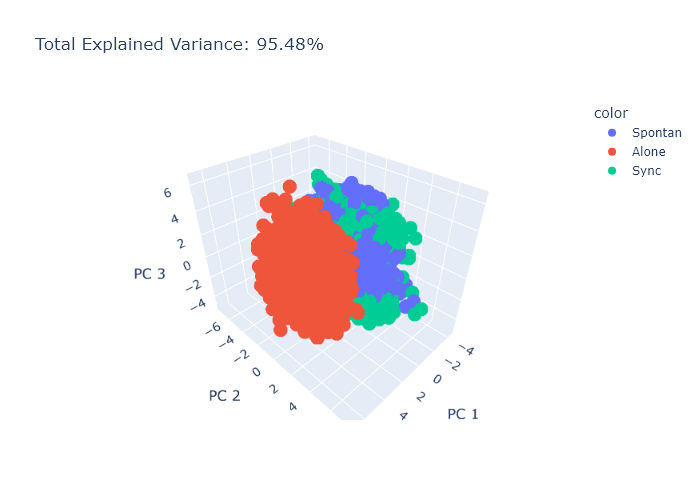

In [118]:
# A three-dimensional graph depicting the way our data is interpreted, plotly does it easily for us 
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter_3d(
    X_train_reduced, x=0, y=1, z=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show("png")

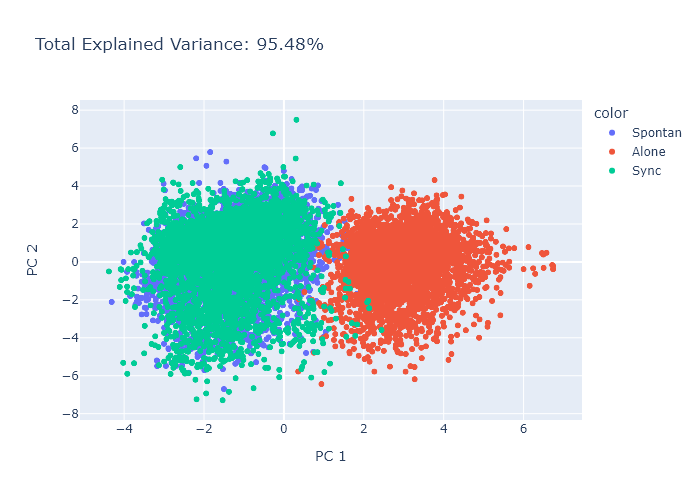

In [119]:
# 2D version: with x and y
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=0, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

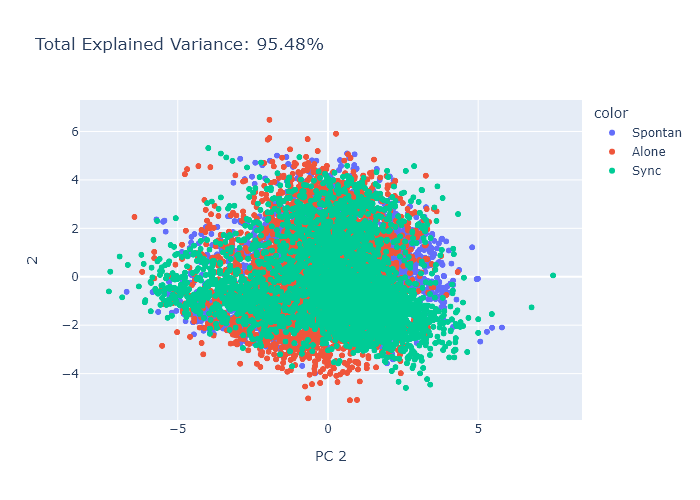

In [120]:
# 2D version: with y and z
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=1, y=2, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

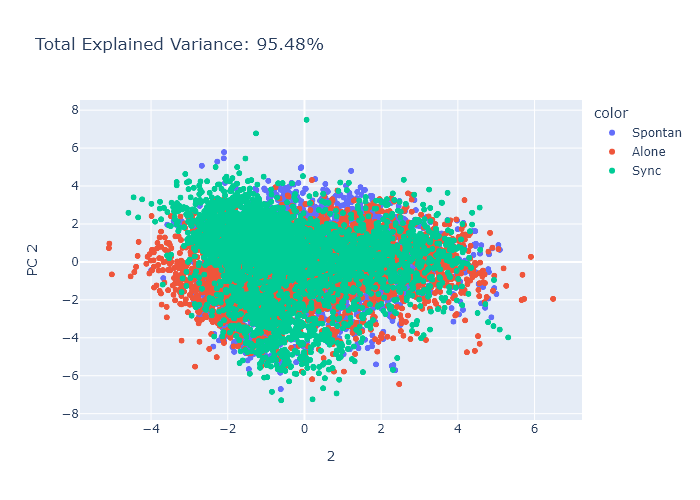

In [121]:
# 2D version: with z and y
total_var = pca.explained_variance_ratio_.sum() * 100
fig = px.scatter(
    X_train_reduced, x=2, y=1, color = num_to_name(y_train),
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show("png")

In [122]:
X_train = pd.DataFrame(X_train_reduced)
X_val = pd.DataFrame(X_val_reduced)

In [123]:
# we will concat our X,y train & validation for cross validation & grid search

X = pd.concat([X_train, X_val], axis = 0)
y = pd.concat([y_train, y_val], axis = 0)

cv_split = [(df_train.loc[df_train["Name"]==0], df_train.loc[df_train["Name"]!=0]),
(df_train.loc[df_train["Name"]==1], df_train.loc[df_train["Name"]!=1])
 


]

# Models

## Naive Bayes:

In [124]:
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes

GaussianNB()

In [125]:
y_pred = bayes.predict(X_val)
bayes_acc = accuracy_score(y_val, y_pred)
bayes_acc

0.8592777085927771

In [126]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1284
           1       0.83      0.73      0.78      1363
           2       0.78      0.85      0.82      1368

    accuracy                           0.86      4015
   macro avg       0.86      0.86      0.86      4015
weighted avg       0.86      0.86      0.86      4015



## KNN:

In [127]:
knn = KNeighborsClassifier()

In [128]:
# I ran grid search on this model. I hide the code because I already found my best params for KNN.

# Grid search

#k_range = list(range(3,51)) # we will test k values in range 3-50
#weight_op = ['uniform', 'distance'] # we will test the knn methods uniform & distance
#d = {'n_neighbors' :k_range, 'weights': weight_op}
#grid_temp = GridSearchCV(knn, d, cv=cv_split, scoring='accuracy') # we chose model, d(range, methods), num of cv groups and scoring method
#grid_temp.fit(X, y)
#print("score:",grid_temp.best_score_," params:",grid_temp.best_params_)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [129]:
knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn.fit(X_train, y_train)
knn

y_pred = knn.predict(X_val)
knn_acc = accuracy_score(y_val, y_pred)
knn_acc

0.8528019925280199

In [130]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1284
           1       0.83      0.72      0.77      1363
           2       0.76      0.85      0.80      1368

    accuracy                           0.85      4015
   macro avg       0.86      0.86      0.85      4015
weighted avg       0.86      0.85      0.85      4015



## Logistic Regression:

In [131]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr

LogisticRegression()

In [132]:
y_pred = lr.predict(X_val)
lr_acc = accuracy_score(y_val, y_pred)
lr_acc

0.7474470734744707

In [133]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1284
           1       0.67      0.52      0.58      1363
           2       0.61      0.74      0.67      1368

    accuracy                           0.75      4015
   macro avg       0.75      0.75      0.75      4015
weighted avg       0.75      0.75      0.74      4015



## CatBoost:

In [134]:
cat = CatBoostClassifier(logging_level='Silent')
cat.fit(X_train, y_train)
cat

In [135]:
y_pred = cat.predict(X_val)
y_pred_cat = y_pred.copy()
cat_acc = accuracy_score(y_val, y_pred)
cat_acc

0.8782067247820673

In [137]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1284
           1       0.85      0.78      0.81      1363
           2       0.81      0.86      0.84      1368

    accuracy                           0.88      4015
   macro avg       0.88      0.88      0.88      4015
weighted avg       0.88      0.88      0.88      4015



## AdaBoost:

In [138]:
rfc = RandomForestClassifier(n_estimators=10)
ada = AdaBoostClassifier(n_estimators=100,learning_rate= 0.1, base_estimator=rfc)
ada.fit(X_train, y_train)
ada

AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=10),
                   learning_rate=0.1, n_estimators=100)

In [139]:
y_pred = ada.predict(X_val)
ada_acc = accuracy_score(y_val, y_pred)
ada_acc

0.8729763387297634

In [140]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1284
           1       0.83      0.79      0.81      1363
           2       0.82      0.83      0.82      1368

    accuracy                           0.87      4015
   macro avg       0.87      0.88      0.87      4015
weighted avg       0.87      0.87      0.87      4015



## Gradient Boosting:

In [141]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb

GradientBoostingClassifier()

In [142]:
y_pred = gb.predict(X_val)
gb_acc = accuracy_score(y_val, y_pred)
gb_acc

0.8351183063511831

In [143]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1284
           1       0.78      0.72      0.75      1363
           2       0.75      0.79      0.77      1368

    accuracy                           0.84      4015
   macro avg       0.84      0.84      0.84      4015
weighted avg       0.83      0.84      0.83      4015



## XGBoosting:

In [144]:
xgb = XGBClassifier(use_label_encoder =False)

In [145]:
# Since I already used grid search, we will hide the code, because we have the params we need for XGB

#params = {"learning_rate"    : [0.05, 0.15, 0.20, 0.30] ,
#          "max_depth"        : [3, 5, 8, 10, 15],
#          "min_child_weight" : [3, 5, 7 ],
#          "gamma"            : [0.0, 0.1, 0.2 , 0.4],
#          "colsample_bytree" : [0.3, 0.5 , 0.7] }

#grid_search = GridSearchCV(xgb, param_grid = params, cv = 4, verbose = 1)
#grid_search.fit(X, y)
#print("score:",grid_search.best_score_," params:",grid_search.best_params_)

In [146]:
#xgb = XGBClassifier(max_depth=10,min_child_weight=5,gamma=0.1,colsample_bytree=0.7) my defult params are better
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_val)
xgb_acc = accuracy_score(y_val, y_pred)
xgb_acc

[16:29:00] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.8687422166874221

In [147]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1284
           1       0.81      0.80      0.81      1363
           2       0.81      0.81      0.81      1368

    accuracy                           0.87      4015
   macro avg       0.87      0.87      0.87      4015
weighted avg       0.87      0.87      0.87      4015



## Random Forest:

In [148]:
rf = RandomForestClassifier()

In [149]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [80, 100],
#    'max_features': [2, 3],
#    'min_samples_leaf': [3, 4, 5],
#    'min_samples_split': [8, 10, 12],

#'n_estimators': [100, 200, 300]
#}

#grid_search = GridSearchCV(rf, param_grid = param_grid, cv = 4, verbose = 1)
#grid_search.fit(X, y)
#print("score:",grid_search.best_score_," params:",grid_search.best_params_)

In [150]:
rf = RandomForestClassifier(bootstrap= True, max_depth= 80, max_features= 3, min_samples_leaf= 3, min_samples_split= 8, n_estimators= 200)

rf.fit(X_train, y_train)
rf

y_pred = rf.predict(X_val)
rf_acc = accuracy_score(y_val, y_pred)
rf_acc

0.8577833125778331

In [151]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1284
           1       0.78      0.82      0.80      1363
           2       0.83      0.76      0.79      1368

    accuracy                           0.86      4015
   macro avg       0.86      0.86      0.86      4015
weighted avg       0.86      0.86      0.86      4015



In [152]:
stacking = StackingClassifier(estimators=[('gxb',xgb),('cat',cat),('knn',knn)],final_estimator=cat)
stacking.fit(X_train,y_train)
stacking

[16:29:08] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:30] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:34] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:29:38] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

StackingClassifier(estimators=[('gxb',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n_jobs=8,
                                              nu...
                                              random_state=0, reg_alpha=0,
               

In [153]:
y_pred = stacking.predict(X_val)
y_pred_stack = y_pred
stacking_acc = accuracy_score(y_val, y_pred)
stacking_acc

0.8679950186799502

In [154]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1284
           1       0.84      0.76      0.80      1363
           2       0.79      0.85      0.82      1368

    accuracy                           0.87      4015
   macro avg       0.87      0.87      0.87      4015
weighted avg       0.87      0.87      0.87      4015



## Voting:

In [155]:
sv = VotingClassifier(estimators=[
        ('xgb', xgb), ('cat', cat), ('knn', knn)], voting='soft') # , ('rf', clf3)
sv.fit(X_train, y_train)
sv

[16:31:25] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child_weight=1, missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                            num_parallel_tree=1,
                                            objective='multi:softprob',
                             

In [156]:
y_pred = sv.predict(X_val)
y_pred_sv = y_pred
sv_acc = accuracy_score(y_val, y_pred)
sv_acc

0.8806973848069738

In [157]:
print (classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1284
           1       0.84      0.80      0.82      1363
           2       0.82      0.85      0.83      1368

    accuracy                           0.88      4015
   macro avg       0.88      0.88      0.88      4015
weighted avg       0.88      0.88      0.88      4015



# Conclusion

In [158]:
acc_list = {'Model':  ['Naive Bayes', 'KNN','Logistic Regression','CatBoost', 'AdaBoost', 'Gradient Boosting', 'XGBoost','Random Forest','Stacking', 'Soft Voting'],
        'Accuracy': [bayes_acc,knn_acc,lr_acc,cat_acc,ada_acc,gb_acc,xgb_acc,rf_acc,stacking_acc,sv_acc],
        }

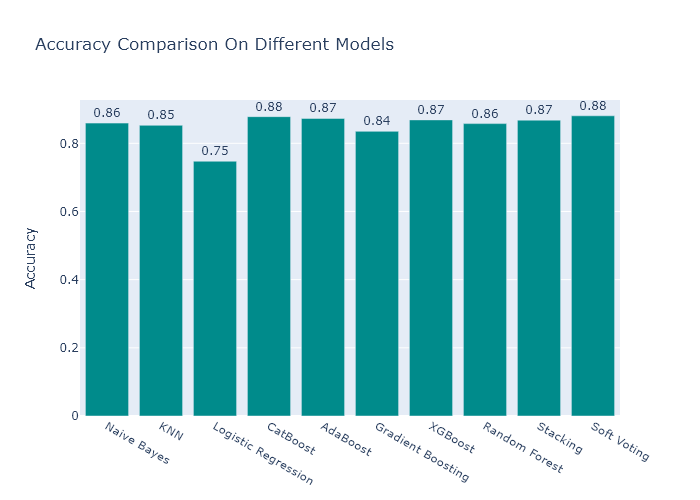

In [159]:
# bar graph as a conclusion to the models
fig = go.Figure(data=[
    go.Bar(name='train set', x=acc_list['Model'], y=acc_list['Accuracy'],text=np.round(acc_list['Accuracy'],2),textposition='outside',marker_color='darkcyan'),
])
fig.update_layout(barmode='group',title_text='Accuracy Comparison On Different Models',yaxis=dict(
        title='Accuracy'))
fig.show("png")

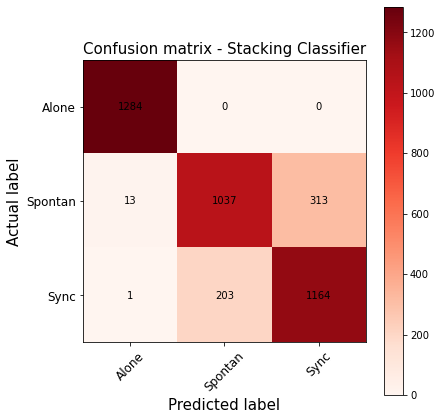

In [160]:
# we would like to present confusion matrix for our best model:

cm = confusion_matrix(y_val, y_pred_stack)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Reds)
plt.title('Confusion matrix - Stacking Classifier', size = 15)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Alone','Spontan','Sync'], rotation=45, size = 12)
plt.yticks(tick_marks, ['Alone','Spontan','Sync'], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

# Test

In [161]:
y_test = df_test['Label'] # the feature we would like to predict, the label of picture
X_test = df_test.drop(['Label',' Frame ID','Name','Time'], axis = 1) # we will drop y from x, because we want to predict it
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

ValueError: X has 36 features, but StandardScaler is expecting 37 features as input.

In [ ]:
y_pred = sv.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
test_acc

In [ ]:
print (classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Reds)
plt.title('Confusion matrix for test', size = 15)
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Alone','Spontan','Sync'], rotation=45, size = 12)
plt.yticks(tick_marks, ['Alone','Spontan','Sync'], size = 12)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')